In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [52]:
#seteo los paramentros para los graficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [53]:
import os

os.listdir()

['.config', 'sample_data']

# Análisis exploratorio de evaluaciones preoperatorias para caracterizar riesgo anestésico

La evaluación preoperatoria constituye una etapa fundamental en la práctica clínica, ya que permite identificar factores de riesgo asociados al paciente y anticipar posibles complicaciones durante el período perioperatorio. Dentro de este proceso, la clasificación ASA (American Society of Anesthesiologists) se utiliza de manera rutinaria para categorizar el estado físico del paciente y estimar su riesgo anestésico global.

El objetivo de este proyecto es analizar un conjunto de datos de evaluaciones preoperatorias mediante técnicas de análisis exploratorio de datos (EDA) y visualizaciones, con el fin de identificar patrones relevantes asociados al riesgo anestésico, la presencia de comorbilidades y la complejidad de los procedimientos quirúrgicos.

Este análisis está dirigido a profesionales de la salud, coordinadores quirúrgicos y equipos de gestión hospitalaria interesados en utilizar datos clínicos para mejorar la planificación quirúrgica, la asignación de recursos y la toma de decisiones preoperatorias.

---

##Este análisis está orientado a:

- Coordinación de quirófano y jefatura de anestesiología  
- Equipos de cirugía y anestesia (planificación de recursos)  
- Gestión hospitalaria (priorización de pacientes, derivaciones e interconsultas)

---

##Las principales preguntas que guían este análisis son:

- ¿Cuál es la distribución de la clase ASA en los pacientes evaluados?
- ¿Cómo varía la clase ASA según la edad y el sexo?
- ¿Qué comorbilidades son más frecuentes en pacientes con ASA III–IV?
- ¿Qué tipos de cirugía concentran una mayor proporción de pacientes de alto riesgo anestésico?
- ¿La baja capacidad funcional se asocia a una clasificación ASA más elevada?


---

Los datos analizados corresponden a evaluaciones preoperatorias realizadas en un único centro asistencial, por lo que los resultados reflejan la casuística y el perfil de pacientes de dicha institución.


---


In [54]:
url = "https://raw.githubusercontent.com/DaniPorticella/proyecto_evaluacion_preoperatoria_coderhouse/main/AnestData_EvalPreop.v3supabase.csv"
df = pd.read_csv(url)
df.head()


,id,created_at,idpatient,dateofbirth,sex,weight,height,allergy,functionalcapacity,heartfailure,...,endocrinedisease,anemia,bleedingdisorder,immunosuppression,surgerytype,asaclass,difficultairway,iduser,neurological,age
0,79,2025-12-31 20:39:56.397662+00,2.501080e+11,00:00.0,F,80.0,160.0,NaN,>4METS,False,...,NaN,False,NaN,False,Endoscopic,2,False,NaN,False,40
1,80,2025-12-31 20:51:19.627217+00,2.501070e+11,00:00.0,F,60.0,158.0,NaN,not_assessable,False,...,NaN,True,NaN,False,Endoscopic,3,False,NaN,False,77
2,81,2025-12-31 20:55:53.196373+00,2.501080e+11,00:00.0,F,90.0,160.0,NaN,>4METS,False,...,NaN,True,NaN,False,Endoscopic,2,False,NaN,False,48
3,82,2025-12-31 20:58:06.590961+00,2.501080e+11,00:00.0,M,80.0,175.0,NaN,>4METS,False,...,NaN,False,NaN,False,Endoscopic,2,False,NaN,False,66
4,83,2025-12-31 21:02:04.79422+00,2.501090e+11,00:00.0,F,93.0,150.0,NaN,>4METS,False,...,hypothyroidism,False,NaN,False,Neurosurgery,3,False,NaN,False,68


## Origen y preparación del dataset

El dataset utilizado en este proyecto proviene de una base de datos propia desarrollada en Supabase, diseñada para registrar evaluaciones preoperatorias anestésicas desde una app creada en FlutterFlow. La base original contiene información clínica relevante como edad, sexo, clasificación ASA, comorbilidades, capacidad funcional, predictores de vía aérea difícil y tipo de cirugía.

El conjunto de datos inicial cuenta con aproximadamente 120 registros correspondientes a evaluaciones reales. Previo al análisis, el dataset fue anonimizado mediante la eliminación de identificadores personales y campos administrativos, conservando únicamente variables clínicas agregadas.



In [55]:
df.shape


(121, 35)

In [56]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  121 non-null    int64  
 1   created_at          121 non-null    object 
 2   idpatient           121 non-null    float64
 3   dateofbirth         116 non-null    object 
 4   sex                 121 non-null    object 
 5   weight              118 non-null    float64
 6   height              105 non-null    float64
 7   allergy             11 non-null     object 
 8   functionalcapacity  121 non-null    object 
 9   heartfailure        121 non-null    bool   
 10  hypertension        121 non-null    bool   
 11  arrhythmia          12 non-null     object 
 12  coronarydisease     121 non-null    bool   
 13  stroke              121 non-null    bool   
 14  peripheral          121 non-null    bool   
 15  valvulardisease     1 non-null      object 
 16  smoking 

In [57]:
df.columns


Index(['id', 'created_at', 'idpatient', 'dateofbirth', 'sex', 'weight',
       'height', 'allergy', 'functionalcapacity', 'heartfailure',
       'hypertension', 'arrhythmia', 'coronarydisease', 'stroke', 'peripheral',
       'valvulardisease', 'smoking', 'copd', 'asthma', 'osa', 'diabetes',
       'canceractive', 'gidisease', 'liverdisease', 'kidneydisease',
       'endocrinedisease', 'anemia', 'bleedingdisorder', 'immunosuppression',
       'surgerytype', 'asaclass', 'difficultairway', 'iduser', 'neurological',
       'age'],
      dtype='object')

### Descripción del dataset original

El dataset original contiene aproximadamente 120 registros correspondientes a evaluaciones preoperatorias anestésicas y un conjunto de variables clínicas y administrativas. Las variables incluyen información demográfica, clasificación ASA, comorbilidades, capacidad funcional, predictores de vía aérea difícil y tipo de cirugía, entre otras.

Previo al análisis, se realizó una revisión de las columnas disponibles con el objetivo de identificar aquellas relevantes para el análisis exploratorio y aquellas que debían ser eliminadas por motivos de ***anonimización*** o por no aportar valor analítico.


In [58]:
#ANONIMIZACION
#seleccion de columnas a eliminar

cols_to_drop = ["id", "created_at", "idpatient", 'iduser']
cols_to_drop


['id', 'created_at', 'idpatient', 'iduser']

In [59]:
df = df.drop(columns=cols_to_drop)

df.head()

,dateofbirth,sex,weight,height,allergy,functionalcapacity,heartfailure,hypertension,arrhythmia,coronarydisease,...,kidneydisease,endocrinedisease,anemia,bleedingdisorder,immunosuppression,surgerytype,asaclass,difficultairway,neurological,age
0,00:00.0,F,80.0,160.0,NaN,>4METS,False,False,NaN,False,...,False,NaN,False,NaN,False,Endoscopic,2,False,False,40
1,00:00.0,F,60.0,158.0,NaN,not_assessable,False,False,NaN,False,...,True,NaN,True,NaN,False,Endoscopic,3,False,False,77
2,00:00.0,F,90.0,160.0,NaN,>4METS,False,True,NaN,False,...,False,NaN,True,NaN,False,Endoscopic,2,False,False,48
3,00:00.0,M,80.0,175.0,NaN,>4METS,False,False,NaN,False,...,False,NaN,False,NaN,False,Endoscopic,2,False,False,66
4,00:00.0,F,93.0,150.0,NaN,>4METS,False,True,NaN,False,...,False,hypothyroidism,False,NaN,False,Neurosurgery,3,False,False,68


##Generación de registros sintéticos

Con el objetivo de cumplir con los requerimientos de tamaño muestral de la entrega y permitir un análisis exploratorio más robusto, **se generaron registros sintéticos adicionales hasta alcanzar un total aproximado de 1000 observaciones**.

La generación de estos datos sintéticos se realizó utilizando Python, respetando las distribuciones y proporciones observadas en el dataset original para variables clave como edad, sexo, clasificación ASA y comorbilidades.

Este enfoque permite ampliar el volumen de datos para fines académicos sin comprometer la privacidad de los pacientes ni alterar la estructura clínica del conjunto de datos.

In [60]:
df_real = df.copy()
df_real.shape

(121, 31)

In [61]:
#calculo cuantos registros sinteticos me faltan

n_real = df_real.shape[0]
n_synthetic = 1000 - n_real

n_real, n_synthetic

(121, 879)

In [62]:
#generacion de los registros sinteticos

df_synthetic = df_real.sample(
    n=n_synthetic,
    replace=True,
    random_state=42
).reset_index(drop=True)

In [63]:
df_real["data_type"] = "real"
df_synthetic["data_type"] = "synthetic"


In [64]:
df_final = pd.concat([df_real, df_synthetic], ignore_index=True)
df_final.shape


(1000, 32)

In [65]:
pd.crosstab(df_final["asaclass"], df_final["data_type"], normalize="columns")


data_type,real,synthetic
asaclass,,
1,0.099174,0.098976
2,0.462810,0.458476
3,0.421488,0.430034
4,0.016529,0.012514


In [66]:
pd.crosstab(df_final["sex"], df_final["data_type"], normalize="columns")


data_type,real,synthetic
sex,,
F,0.652893,0.656428
M,0.347107,0.343572


In [67]:
#voy a sacar la columna data_type para el analisis de datos

df_eda = df_final.drop(columns=["data_type"])
df_eda.shape


(1000, 31)

##Valores faltantes y limpieza de datos

Durante la inspección de valores faltantes se observó que varias variables correspondientes a comorbilidades presentaban valores nulos. En el contexto del formulario clínico utilizado, estos valores nulos no representan datos faltantes reales, sino la ausencia de la condición evaluada, ya que únicamente se registra explícitamente la presencia de una comorbilidad.

Por este motivo, en las variables clínicas booleanas se reemplazaron los valores nulos por `False`, haciendo explícita la ausencia de la condición. Este enfoque permite una interpretación clínica correcta y evita sesgos en el análisis exploratorio.


In [68]:
df_eda.isna().sum().sort_values(ascending=False)

,0
valvulardisease,981
bleedingdisorder,964
arrhythmia,901
allergy,895
diabetes,855
smoking,847
endocrinedisease,829
height,138
dateofbirth,33
weight,23


In [69]:
#Hay muchos nulos en algunas columnas, porque al no tener la enfermedad,
#se marca NULL por defecto.
#voy a cambiar esos NULL de los campos booleanos por FALSE

boolean_cols = [
    "valvulardisease", "bleedingdisorder", "arrhythmia", "allergy",
    "diabetes", "smoking", "endocrinedisease", "heartfailure",
    "hypertension", "copd", "peripheral", "coronarydisease", "stroke",
    "canceractive", "gidisease", "osa", "asthma", "kidneydisease",
    "liverdisease", "immunosuppression", "anemia", "neurological",
    "difficultairway"
]


In [70]:
df_eda[boolean_cols] = df_eda[boolean_cols].fillna(False)


In [71]:
df_eda[boolean_cols].isna().sum()


,0
valvulardisease,0
bleedingdisorder,0
arrhythmia,0
allergy,0
diabetes,0
smoking,0
endocrinedisease,0
heartfailure,0
hypertension,0
copd,0


## Creación de la variable BMI

Como parte del proceso de transformación de los datos, se calculó el índice de masa corporal (BMI) a partir de las variables de peso y altura. La altura fue convertida de centímetros a metros para aplicar la fórmula estándar del BMI (kg/m²).

Esta variable derivada se incorporó al análisis por su relevancia clínica en la evaluación preoperatoria y su potencial asociación con el riesgo anestésico.




In [72]:
df_eda[["weight", "height"]].head()

,weight,height
0,80.0,160.0
1,60.0,158.0
2,90.0,160.0
3,80.0,175.0
4,93.0,150.0


In [73]:
df_eda["height_m"] = df_eda["height"] / 100


In [74]:
df_eda["bmi"] = df_eda["weight"] / (df_eda["height_m"] ** 2)


In [75]:
df_eda = df_eda.drop(columns=["height_m"])


In [76]:
df_eda[["weight", "height", "bmi"]].head()


,weight,height,bmi
0,80.0,160.0,31.250000
1,60.0,158.0,24.034610
2,90.0,160.0,35.156250
3,80.0,175.0,26.122449
4,93.0,150.0,41.333333


In [77]:
df_eda["bmi"].describe()


,bmi
count,862.000000
mean,27.733178
std,5.611342
min,17.087445
25%,23.875115
50%,26.672763
75%,31.250000
max,49.947971


#Pregunta 1: ¿Cuál es la distribución de la clase ASA en los pacientes evaluados?

### Clasificación ASA (American Society of Anesthesiologists)

La clasificación ASA es un sistema ampliamente utilizado para estimar el estado físico preoperatorio de los pacientes y su riesgo anestésico. Se trata de una escala ordinal categórica, donde cada clase representa un mayor nivel de compromiso clínico:

- **ASA I**: Paciente sano, sin enfermedad sistémica.
- **ASA II**: Paciente con enfermedad sistémica leve o bien controlada.
- **ASA III**: Paciente con enfermedad sistémica grave que limita la actividad, pero no es incapacitante.
- **ASA IV**: Paciente con enfermedad sistémica grave que constituye una amenaza constante para la vida.

Dado su carácter categórico ordinal, la clasificación ASA se describe mediante frecuencias y porcentajes, y no mediante promedios.


In [78]:
asa_pct = (
    df_eda["asaclass"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

asa_pct


,proportion
asaclass,
1,9.9
2,45.9
3,42.9
4,1.3


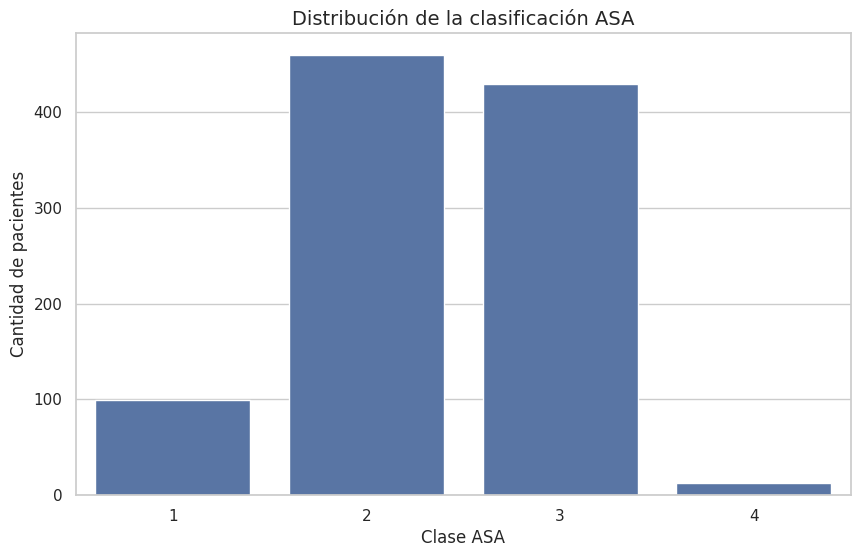

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    data=df_eda,
    x="asaclass",
    order=sorted(df_eda["asaclass"].unique())
)

plt.title("Distribución de la clasificación ASA")
plt.xlabel("Clase ASA")
plt.ylabel("Cantidad de pacientes")
plt.show()


### Insight – Distribución de clase ASA

El análisis muestra que la mayor proporción de pacientes corresponde a clases ASA II y ASA III. En particular, aproximadamente el **45.9%** de los pacientes se clasifica como ASA II y el **42.9%** como ASA III.

La proporción de pacientes ASA I es menor (**9.9%**), mientras que los pacientes ASA IV representan un porcentaje reducido (**1.3%**), lo cual resulta esperable en el contexto de evaluaciones preoperatorias programadas. Esta distribución refleja una población con una carga relevante de comorbilidades leves a moderadas, con impacto directo en la planificación anestésica.

---

#Pregunta 2: ¿Cómo varía la clase ASA según la edad y el sexo?

##2.1. Relación entre edad y clase ASA

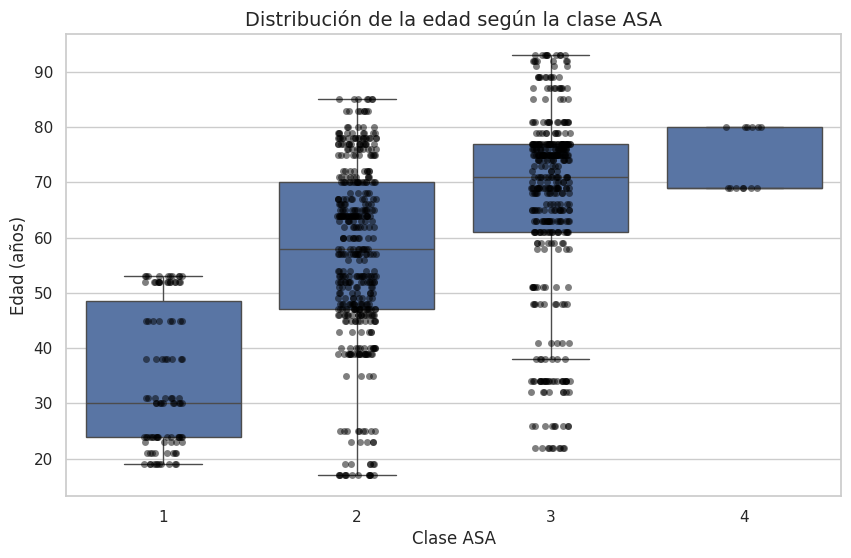

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

order = [1, 2, 3, 4]

sns.boxplot(
    data=df_eda,
    x="asaclass",
    y="age",
    order=order,
    showfliers=False
)

sns.stripplot(
    data=df_eda,
    x="asaclass",
    y="age",
    order=order,
    color="black",
    alpha=0.5,
    jitter=True
)

plt.title("Distribución de la edad según la clase ASA")
plt.xlabel("Clase ASA")
plt.ylabel("Edad (años)")
plt.show()


##Insight – Relación entre edad y clase ASA

El análisis de la distribución de la edad según la clase ASA muestra una asociación clara entre mayor edad y mayor riesgo anestésico.

Los pacientes clasificados como ASA I presentan edades predominantemente más bajas, mientras que las clases ASA II y III concentran pacientes de mayor edad, con medianas progresivamente más elevadas y mayor dispersión.

Este patrón es consistente con el aumento de comorbilidades asociado al envejecimiento, que impacta directamente en la clasificación ASA durante la evaluación preoperatoria.

.

Aclaracion: La clase ASA IV presenta un número reducido de observaciones y valores incompletos en la variable edad. Con el objetivo de evitar imputaciones que pudieran distorsionar la interpretación clínica, esta categoría no fue incluida en el análisis de edad según clase ASA. No obstante, ASA IV fue considerada en el resto de los análisis descriptivos del estudio.

---


##2.1. Relación entre sexo y clase ASA

In [81]:
sex_asa_prop = (
    pd.crosstab(df_eda["sex"], df_eda["asaclass"], normalize="index") * 100
)

sex_asa_prop


asaclass,1,2,3,4
sex,,,,
F,11.432927,45.579268,42.987805,0.00000
M,6.976744,46.511628,42.732558,3.77907


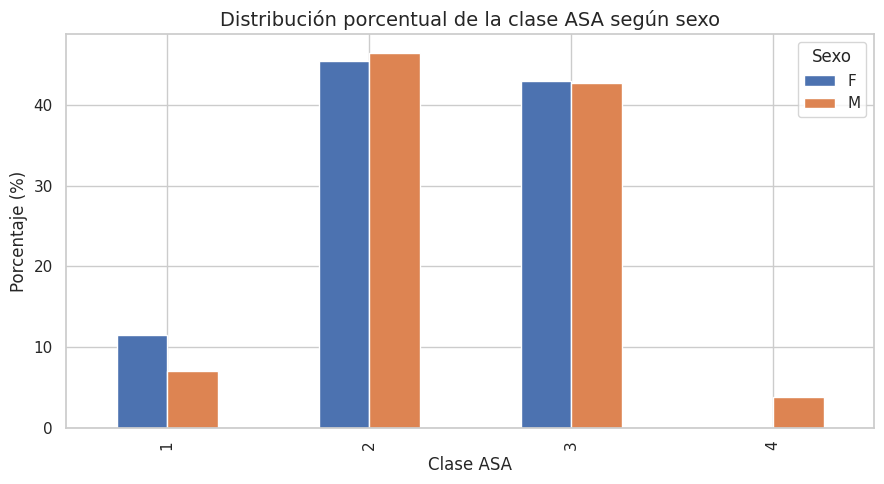

In [82]:
sex_asa_prop.T.plot(
    kind="bar",
    figsize=(9, 5)
)

plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase ASA")
plt.title("Distribución porcentual de la clase ASA según sexo")
plt.legend(title="Sexo")
plt.tight_layout()
plt.show()


##Insight - Relacion entre sexo y clase ASA

El análisis de la distribución porcentual de la clase ASA según sexo muestra una distribución globalmente similar entre mujeres y varones. En ambos grupos, la mayor proporción de pacientes corresponde a las clases ASA II y ASA III, lo que indica un perfil de riesgo anestésico predominantemente intermedio en la población evaluada.


Se observa una leve mayor proporción de pacientes ASA I en el sexo femenino, mientras que el sexo masculino presenta una mayor representación en la clase ASA IV, aunque esta última corresponde a un número reducido de casos.

En conjunto, las diferencias entre sexos son moderadas, lo que sugiere que el sexo por sí solo no constituye un determinante principal de la clasificación ASA en esta cohorte.

---



#Pregunta 3: ¿Qué comorbilidades son más frecuentes en pacientes con ASA alto (III–IV)?


La **clasificación ASA** (*American Society of Anesthesiologists*) es un sistema ampliamente utilizado para estimar el estado físico preoperatorio de los pacientes y su riesgo anestésico. En este análisis, los pacientes fueron agrupados en dos categorías:

**ASA bajo (I–II)**: pacientes sanos o con enfermedad sistémica leve, sin limitaciones funcionales significativas.

**ASA alto (III–IV)**: pacientes con enfermedad sistémica severa, con impacto funcional o compromiso clínico relevante, asociados a mayor riesgo perioperatorio.

Esta agrupación permite comparar de forma clara la carga de comorbilidades entre pacientes de bajo y alto riesgo anestésico.



In [83]:
#separamos en dos grupos: asa bajo (1-2), asa alto (3-4)

df_eda["asa_risk"] = df_eda["asaclass"].apply(
    lambda x: "Alto (III–IV)" if x >= 3 else "Bajo (I–II)"
)

df_eda["asa_risk"].value_counts()


,count
asa_risk,
Bajo (I–II),558
Alto (III–IV),442


In [84]:
#defino comorbilidades

comorbidities_bool = [
    "heartfailure", "hypertension", "coronarydisease", "stroke",
    "peripheral", "copd", "asthma", "osa", "canceractive",
    "gidisease", "liverdisease", "kidneydisease", "anemia",
    "immunosuppression", "difficultairway", "neurological"
]


In [85]:
#calculo de frecuencia de comorbilidades en asa alto vs asa bajo

comorb_by_asa = (
    df_eda
    .groupby("asa_risk")[comorbidities_bool]
    .mean()
    .T * 100
)

comorb_by_asa


asa_risk,Alto (III–IV),Bajo (I–II)
heartfailure,8.597285,0.000000
hypertension,54.977376,25.806452
coronarydisease,5.429864,0.000000
stroke,7.013575,0.000000
peripheral,3.619910,0.000000
copd,10.633484,0.000000
asthma,6.561086,4.121864
osa,4.751131,0.000000
canceractive,15.384615,10.573477
gidisease,19.004525,15.770609


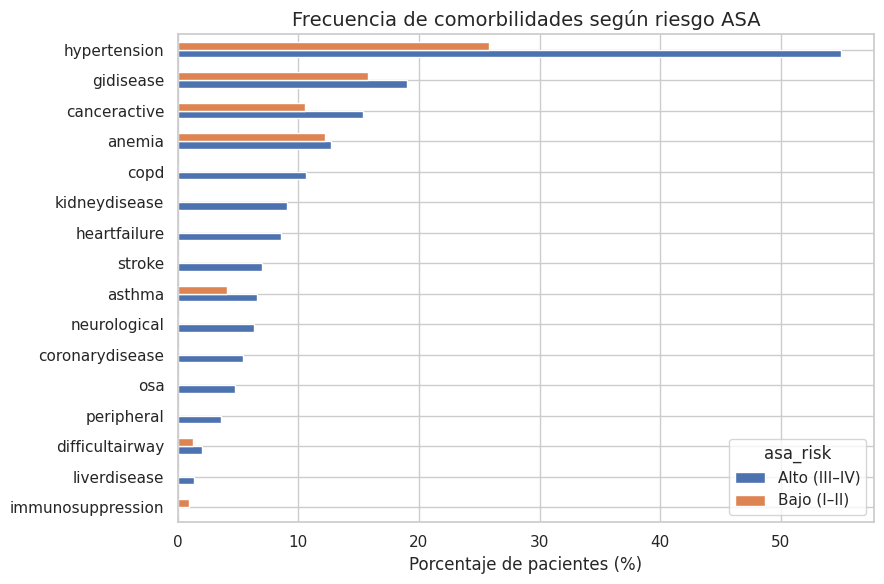

In [86]:
comorb_by_asa.sort_values("Alto (III–IV)").plot(
    kind="barh", figsize=(9,6)
)

plt.xlabel("Porcentaje de pacientes (%)")
plt.title("Frecuencia de comorbilidades según riesgo ASA")
plt.tight_layout()
plt.show()


##Insight – Comorbilidades según riesgo ASA

Al comparar la frecuencia de comorbilidades entre pacientes con riesgo anestésico bajo (ASA I–II) y alto (ASA III–IV), se observa una mayor prevalencia de múltiples patologías crónicas en el grupo ASA alto. Las diferencias son particularmente marcadas en comorbilidades cardiovasculares, respiratorias y sistémicas, como hipertensión arterial, enfermedad cardiovascular, EPOC, anemia y enfermedad renal.

Este patrón es consistente con la definición clínica de la clasificación ASA, que refleja la carga global de enfermedad sistémica del paciente. El análisis exploratorio confirma que los pacientes clasificados como ASA III–IV concentran una mayor complejidad clínica, lo cual tiene implicancias directas en la planificación anestésica, la asignación de recursos y la evaluación del riesgo perioperatorio.

---

#Pregunta 4: ¿Qué tipos de cirugía concentran una mayor proporción de pacientes de alto riesgo anestésico?

In [87]:
surgery_asa = (
    pd.crosstab(
        df_eda["surgerytype"],
        df_eda["asa_risk"],
        normalize="index"
    ) * 100
)

surgery_asa


asa_risk,Alto (III–IV),Bajo (I–II)
surgerytype,,
Cardiovascular,88.679245,11.320755
Endoscopic,50.000000,50.000000
General,53.608247,46.391753
Gynecologic,0.000000,100.000000
Neurosurgery,51.865672,48.134328
Orthopedic,100.000000,0.000000
Other,20.454545,79.545455
Plastic,0.000000,100.000000
Urologic,11.666667,88.333333


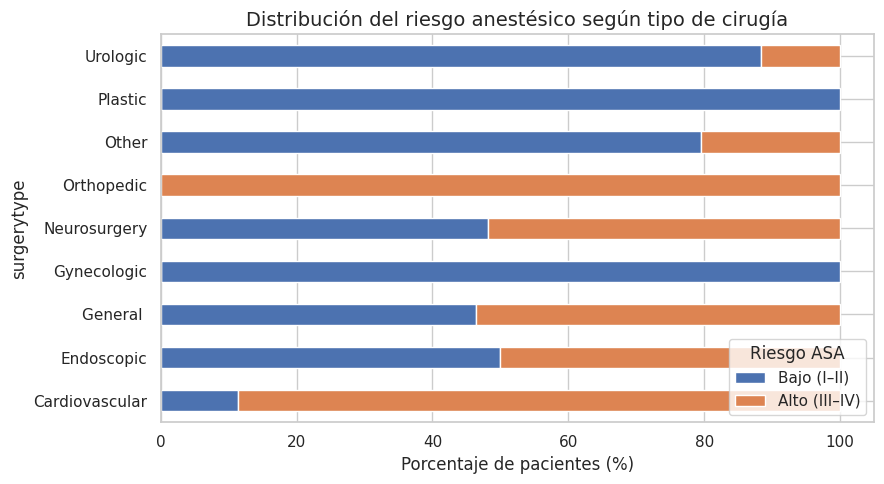

In [88]:
surgery_asa = surgery_asa.loc[:, ["Bajo (I–II)", "Alto (III–IV)"]]

surgery_asa.plot(
    kind="barh",
    stacked=True,
    figsize=(9,5)
)

plt.xlabel("Porcentaje de pacientes (%)")
plt.title("Distribución del riesgo anestésico según tipo de cirugía")
plt.legend(title="Riesgo ASA", loc="lower right")
plt.tight_layout()
plt.show()


##Insight - Tipo de cirugia y riesgo anestesico

La distribución del riesgo anestésico varía de manera marcada según el tipo de cirugía. En el centro analizado, los procedimientos cardiovasculares, ortopédicos y neuroquirúrgicos concentran una mayor proporción de pacientes clasificados como ASA III–IV, lo que refleja una mayor complejidad clínica y riesgo perioperatorio.

En contraste, las cirugías ginecológicas, plásticas y urológicas presentan predominantemente pacientes ASA I–II, sugiriendo un perfil de menor riesgo anestésico.

Este análisis permite identificar tipos de procedimientos que requieren una planificación anestésica más intensiva y una mayor asignación de recursos.

---

#Pregunta 5: ¿La baja capacidad funcional se asocia a una clasificación ASA más elevada?

La capacidad funcional es un indicador clínico clave en la evaluación preoperatoria, ya que refleja la reserva fisiológica del paciente y su tolerancia al estrés quirúrgico. Habitualmente se expresa en términos de la capacidad para realizar actividades cotidianas y se asocia con el consumo metabólico de oxígeno (METs). **Una capacidad funcional disminuida se ha vinculado a un mayor riesgo de complicaciones perioperatorias y suele reflejar la presencia de enfermedad sistémica significativa.**

En este análisis se evalúa la relación entre la capacidad funcional reportada y la clasificación ASA, con el objetivo de explorar si los pacientes con menor capacidad funcional presentan una mayor proporción de riesgo anestésico elevado.


In [89]:
fc_asa = (
    pd.crosstab(
        df_eda["functionalcapacity"],
        df_eda["asa_risk"],
        normalize="index"
    ) * 100
)

fc_asa


asa_risk,Alto (III–IV),Bajo (I–II)
functionalcapacity,,
<4METS,100.000000,0.000000
>4METS,31.722429,68.277571
not_assessable,96.111111,3.888889


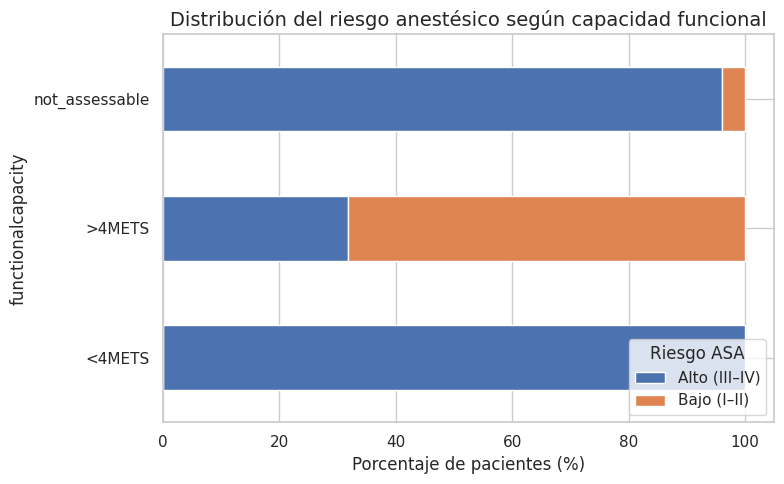

In [90]:
fc_asa.plot(
    kind="barh",
    stacked=True,
    figsize=(8,5)
)

plt.xlabel("Porcentaje de pacientes (%)")
plt.title("Distribución del riesgo anestésico según capacidad funcional")
plt.legend(title="Riesgo ASA", loc="lower right")
plt.tight_layout()
plt.show()


##Insight - Capacidad funcional y clase ASA

El análisis muestra una asociación clara entre la capacidad funcional y la clasificación ASA. Los pacientes con capacidad funcional disminuida presentan una mayor proporción de riesgo anestésico elevado (ASA III–IV), mientras que aquellos con buena capacidad funcional se concentran mayoritariamente en las categorías de menor riesgo (ASA I–II).

Este hallazgo es consistente con el rol de la capacidad funcional como indicador de reserva fisiológica y carga de enfermedad sistémica, y refuerza su importancia en la evaluación preoperatoria y en la estratificación del riesgo anestésico.

---

#Conclusión

A través del análisis exploratorio de datos de evaluaciones preoperatorias realizadas en un único centro asistencial, este proyecto permitió identificar patrones relevantes asociados al riesgo anestésico y a la complejidad clínica de los pacientes.

La clasificación ASA mostró una distribución coherente con la práctica clínica, asociándose de manera consistente con variables clave como la edad, la carga de comorbilidades, el tipo de cirugía y la capacidad funcional. En particular, los pacientes clasificados como ASA III–IV presentaron una mayor prevalencia de enfermedades crónicas, una menor capacidad funcional y una mayor concentración en determinados tipos de procedimientos quirúrgicos, lo que refleja un perfil de mayor riesgo perioperatorio.

Estos hallazgos refuerzan el valor de la evaluación preoperatoria sistemática y del uso de herramientas de análisis de datos para apoyar la toma de decisiones clínicas y organizativas. Si bien los resultados deben interpretarse en el contexto de la casuística local del centro analizado, el enfoque presentado demuestra cómo el análisis exploratorio y las visualizaciones pueden transformar datos clínicos en insights accionables para la planificación quirúrgica, la asignación de recursos y la gestión hospitalaria.